<a href="https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/sign_detector_augmentated_v1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/sign_detector.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

In [1]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip
    !rm rtsd-dataset.zip
    !cp -r rtsd-frames/rtsd-frames/ .
    !rm -r rtsd-frames/rtsd-frames/
    !pip install fiftyone
if colab == True:
    dataset_path = '.'
    checkpoints_path = '../content/drive/MyDrive/TSR/checkpoints'
else:
    dataset_path = 'data'
    checkpoints_path = 'checkpoints'

import os
import json
import numpy as np 
import pandas as pd 

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from pycocotools.coco import COCO
import fiftyone as fo
import time
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
#import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
import cv2

## Обучение модели

In [ ]:
#from PIL import Image
#img = Image.open('data/rtsd-frames/autosave01_02_2012_09_16_49.jpg').convert("RGB")
#img

### Загрузчик данных

In [2]:
# Преобразование классов знаков в 1 класс
def anno_to_bin_class(anno_file):
    '''Функция создает копию файла с аннотацией, преобразует все классы в 1 (знак)
    и сохраняет новый файл с аннотацией'''
    with open(os.path.join(dataset_path, anno_file), 'r') as read_file:
        anno_json = json.load(read_file)
    read_file.close()

    for i in range(len(anno_json['annotations'])):
        anno_json['annotations'][i]['category_id'] = 1    
    
    anno_json['categories'] = [{'id': 1, 'name': 'sign'}]
    
    anno_file_new = anno_file.split('.')[0] + '_bin_class.json'
    
    with open(os.path.join(dataset_path, anno_file_new), 'w') as f:
        json.dump(anno_json, f)#ensure_ascii=False, indent=4)
    f.close()

    return anno_json
anno_to_bin_class('train_anno.json')
anno_to_bin_class('train_anno_reduced.json')
anno_to_bin_class('val_anno.json')


{'images': [{'id': 22978,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave10_10_2012_13_50_36_1.jpg'},
  {'id': 53820,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave24_10_2012_10_20_51_2.jpg'},
  {'id': 52206,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave23_10_2012_14_41_26_0.jpg'},
  {'id': 48186,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave23_10_2012_10_16_35_2.jpg'},
  {'id': 41953,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave16_10_2012_11_44_25_2.jpg'},
  {'id': 38421,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave16_10_2012_08_45_17_4.jpg'},
  {'id': 27187,
   'width': 1920,
   'height': 1080,
   'file_name': 'rtsd-frames/autosave13_04_2013_13_38_32_1.jpg'},
  {'id': 19104,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave10_10_2012_10_00_59_0.jpg'},
  {'id': 58486,
   'width': 1280,
   'height'

In [4]:
class RTSD_dataset(Dataset):
  
    def __init__(self, json_path, img_path, transforms):
        self.json_path = json_path
        self.img_path = img_path
        self.tranfforms = transforms

        with open(json_path, 'r') as read_file:
            self.anno = json.load(read_file)
        read_file.close()

        self.df_dataset = pd.DataFrame(self.anno.get('annotations'))
        self.test = self.df_dataset.copy()
        #self.test['bbox_for_rcnn'] = self.test.bbox[0]
        self.df_images = pd.DataFrame(self.anno.get('images'))
        self.df_images.rename(columns={'id':'image_id'}, inplace=True)
        self.df_dataset = self.df_dataset.merge(self.df_images)
        self.df_dataset = self.df_dataset[['file_name', 'bbox', 'category_id']].groupby('file_name', as_index=False).agg(list)

    def get_df(self):
        #return self.df_dataset
        return self.test

    def __len__(self):
        return self.df_dataset.shape[0]
  
    def __getitem__(self, index):
        img_name = self.df_dataset.loc[index,'file_name']
        img = cv2.imread(os.path.join(self.img_path, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        #img = torch.from_numpy(img).permute(2, 0, 1).to(torch.float)
        img = img/255.
        #img = Image.open(os.path.join(self.img_path, img_name))
        #img = np.array(img)
        
        boxes = []
        for box in self.df_dataset.loc[index,'bbox']:
            box_for_rcnn = [box[0], box[1], box[0] + box[2], box[1] + box[3]]
            boxes.append(box_for_rcnn)
        boxes = torch.Tensor(boxes).to(torch.float)            # возможно нужно преобразовать x_max и y_max
        #boxes = torch.Tensor(self.df_dataset.loc[index, 'bbox']).to(torch.float)
        labels = torch.Tensor(self.df_dataset.loc[index, 'category_id']).to(torch.int64)
        #area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 0])
        #iscrowd = torch.zeros(labels.shape[0], dtype=torch.int64)
        
        #transform = self.tranfforms
        #transformed = transform(image=img, bboxes=boxes, labels=labels)
        transformed = self.tranfforms(image=img, bboxes=boxes, labels=labels)
        img = transformed['image']
        boxes = torch.Tensor(transformed['bboxes'])
        #for i in range(10):
        try:
            boxes.shape[1]
        except:
            img_name = self.df_dataset.loc[index,'file_name']
            img = cv2.imread(os.path.join(self.img_path, img_name))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
            img = img/255.
            boxes = []
            for box in self.df_dataset.loc[index,'bbox']:
                box_for_rcnn = [box[0], box[1], box[0] + box[2], box[1] + box[3]]
                boxes.append(box_for_rcnn)
            boxes = torch.Tensor(boxes).to(torch.float)            # возможно нужно преобразовать x_max и y_max
            labels = torch.Tensor(self.df_dataset.loc[index, 'category_id']).to(torch.int64)
            transformed = self.tranfforms(image=img, bboxes=boxes, labels=labels)
            img = transformed['image']
            boxes = torch.Tensor(transformed['bboxes'])
            
        #if self.transforms is not None:    
        #    img, target = self.transforms(img, target)

        #img = img/255.
        target = {}
        target['boxes'] = boxes
        target['labels'] = torch.Tensor(self.df_dataset.loc[index, 'category_id']).to(torch.int64)
        return img, target

In [5]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
    # Send train=True fro training transforms and False for val/test transforms
def get_transform(train=False):
    if train==True:
        return A.Compose([A.HorizontalFlip(p=0.5),
                          A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
                          A.RandomFog(fog_coef_lower=0.2, fog_coef_upper=0.3, alpha_coef=0.1, p=0.05), #Туман
                          A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=5, p=0.05),
                          A.Rotate(limit=10, p=0.5),
                          #A.RandomShadow(num_shadows_lower=1, num_shadows_upper=1, shadow_dimension=5, shadow_roi=(0, 0.5, 1, 1), p=1),
                          #A.RandomSnow(brightness_coeff=1.5, snow_point_lower=0.3, snow_point_upper=0.5, p=1),
                          #A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0.5, p=1),
                          # ToTensorV2 converts image to pytorch tensor without div by 255
                          ToTensorV2(p=1.0)
                          ],
                          bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
        
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [ ]:
'''import torchvision.transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)'''

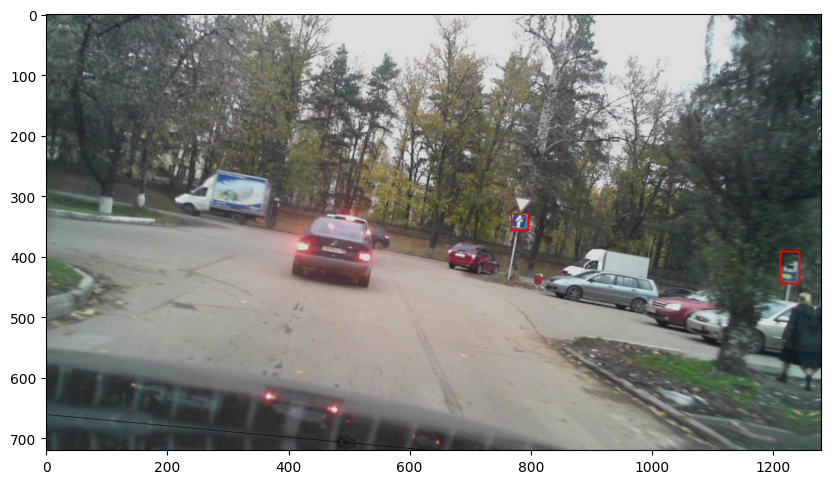

In [10]:
%matplotlib inline
test = RTSD_dataset(json_path = os.path.join(dataset_path, 'train_anno_reduced_bin_class.json'),
                    img_path = dataset_path,
                    transforms = get_transform(train=True)
                    )
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(10,10)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 1,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
#img, target = my_dataset[25]
img, target = test.__getitem__(1223)
img = img.permute(1, 2, 0).detach().numpy()
img = img*255
img = img.astype(np.uint8)
plot_img_bbox(img, target)

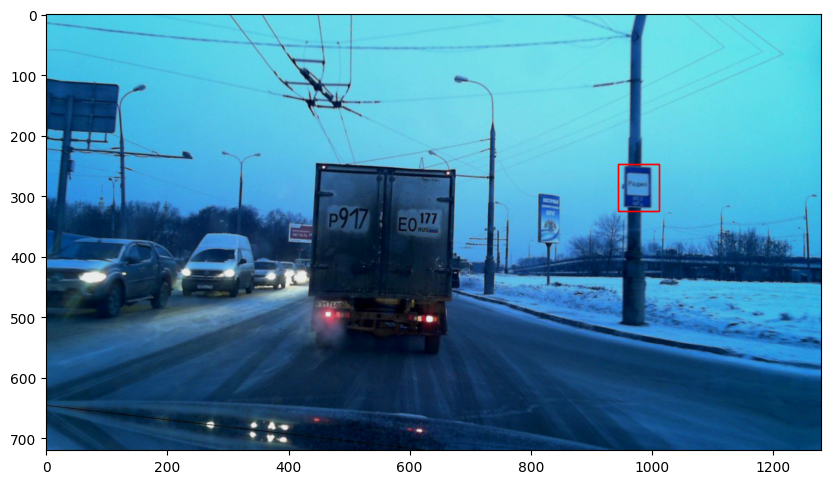

In [12]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(10,10)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 1,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
#img, target = my_dataset[25]
img, target = test.__getitem__(1)
img = img.permute(1, 2, 0).detach().numpy()
img = img*255
img = img.astype(np.uint8)
plot_img_bbox(img, target)

In [13]:
del test

### Формирование батча

In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))

### Гиперпараметры

In [14]:
device_id = 0
if torch.cuda.is_available() == True:
    device = f'cuda:{device_id}'
elif torch.backends.mps.is_available() == True:
    device = 'mps'
else:
    device = 'cpu'


model_name = 'resnet50_augmented'
#model_name = 'resnet50_v2_augmented'

# эпоха для загрузки параметров, обучение начинается со следующей
last_epoch = None
n_epochs = 10       # полное количество эпох для обучения
batch_size = 8
num_classes = 2

device

'cuda:0'

### Инициализация модели, задание оптимизатора и функции потерь

In [19]:
def create_model(model_name, num_classes):
    # load model pre-trained on COCO
    if 'resnet50_v2' in model_name:
        model =torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT')
        print("Загружена модель resnet50_v2")
    elif 'resnet50' in model_name:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1')
        print("Загружена модель resnet50")
    else:
        print("Проверить название модели")
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [18]:
model = create_model(model_name=model_name, num_classes=2).to(device)

# parameters
params = [p for p in model.parameters() if p.requires_grad]

# optimizer
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)

# learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# Загрузка весов модели, состояния оптимизатора и шедулера
if last_epoch is not None:
    checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_detector_{model_name}_b{batch_size}_{last_epoch}.pth'), map_location=device)
    print(f'Для модели {model_name} с размером батча {batch_size} загружены веса {last_epoch} эпохи')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])

train_dataset = RTSD_dataset(os.path.join(dataset_path, 'train_anno_bin_class.json'),
                                          dataset_path,
                                          transforms = get_transform(train=False)
                                          )

val_dataset = RTSD_dataset(os.path.join(dataset_path, 'val_anno_bin_class.json'),
                                        dataset_path,
                                          transforms = get_transform(train=False)
                                          )

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

UnboundLocalError: local variable 'model' referenced before assignment

### Трейн луп

In [9]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"\tЭпоха {epoch}. Итерация {i}/{len_dataloader}. Loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader, epoch):
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss 

In [24]:
checkpoint['losses_val']

[0.0056146160304546356,
 0.005224747147411108,
 0.005272344498336315,
 0.005582686723768711,
 0.005126563803851605,
 0.005666033986210823,
 0.0051099161364138125,
 0.005101670296490193]

In [25]:
val_loss = val(val_data_loader, 7)
val_loss

0.010203415737301111

In [10]:
# Загрузка словарей с лоссами
if last_epoch is not None:
    start_epoch = last_epoch +1
    train_losses = checkpoint['losses_train']
    val_losses = checkpoint['losses_val']
    
else:
    start_epoch = 0
    train_losses = []
    val_losses = []

try:
    for epoch in range(start_epoch, n_epochs):
        start = time.time()
        train_loss = train(train_data_loader, epoch)
        val_loss = val(val_data_loader, epoch)
        lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'losses_train': train_losses,
            'losses_val': val_losses
            }, os.path.join(checkpoints_path, f'chkpt_detector_{model_name}_b{batch_size}_{epoch}.pth'))
    
        torch.save(model, os.path.join(checkpoints_path, f'model_detector_{model_name}_b{batch_size}_{epoch}.pth'))
    
except KeyboardInterrupt:
    print('Прервано пользователем') 

	Эпоха 5. Итерация 0/6774. Loss: 0.04880989342927933
	Эпоха 5. Итерация 50/6774. Loss: 0.060184162110090256
	Эпоха 5. Итерация 100/6774. Loss: 0.0407627671957016
	Эпоха 5. Итерация 150/6774. Loss: 0.22527402639389038
	Эпоха 5. Итерация 200/6774. Loss: 0.08420317620038986
	Эпоха 5. Итерация 250/6774. Loss: 0.07887144386768341
	Эпоха 5. Итерация 300/6774. Loss: 0.07141557335853577
	Эпоха 5. Итерация 350/6774. Loss: 0.06115887314081192
	Эпоха 5. Итерация 400/6774. Loss: 0.08324676752090454
	Эпоха 5. Итерация 450/6774. Loss: 0.057084135711193085
	Эпоха 5. Итерация 500/6774. Loss: 0.06390448659658432
	Эпоха 5. Итерация 550/6774. Loss: 0.1199895367026329
	Эпоха 5. Итерация 600/6774. Loss: 0.07009171694517136
	Эпоха 5. Итерация 650/6774. Loss: 0.07614131271839142
	Эпоха 5. Итерация 700/6774. Loss: 0.10534492880105972
	Эпоха 5. Итерация 750/6774. Loss: 0.09075817465782166
	Эпоха 5. Итерация 800/6774. Loss: 0.07645656168460846
	Эпоха 5. Итерация 850/6774. Loss: 0.1391635686159134
	Эпоха 5. Итер

AssertionError: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([0]).

In [26]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'losses_train': train_losses,
            'losses_val': val_losses
            }, os.path.join(checkpoints_path, f'chkpt_{model_name}_{epoch}.pth'))
    
torch.save(model, os.path.join(checkpoints_path, f'model_{model_name}_{epoch}.pth'))

In [ ]:
checkpoints_path

'../checkpoints'

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'losses_train': train_losses,
            'losses_val': val_losses
            }, os.path.join(checkpoints_path, f'model_detector_resnet50_augmented_{epoch}.pth'))

In [ ]:
checkpoint2 = torch.load(os.path.join('checkpoints', f'model_detector_resnet50_augmented_2.pth'), map_location=device)


In [ ]:
checkpoint3 = torch.load(os.path.join('checkpoints', f'model_detector_resnet50_augmented_3.pth'), map_location=device)

In [ ]:
checkpoint2['losses_train']

[0.006822872471820277, 0.00596496530648258, 0.005799468892012618]

In [ ]:
checkpoint3['losses_train']

[0.006822872471820277,
 0.00596496530648258,
 0.005799468892012618,
 0.011846726517383244]

In [ ]:
train_losses, val_losses

([0.014400107387186303], [0.010745501028001309])

In [ ]:
'''torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    'losses_train': train_losses,
    'losses_val': val_losses
    }, os.path.join(dataset_path, f'../checkpoints/model_detector_resnet50_augmented_{epoch}.pth'))'''

In [ ]:
def create_model(num_classes, pretrained=True):
    model =torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights='FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
model = create_model(num_classes=2, pretrained=True).to(device)




# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

#params = [p for p in model.parameters() if p.requires_grad]

#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)



#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
train_dataset = RTSD_dataset(os.path.join(dataset_path, 'train_anno_bin_class.json'),
                                          dataset_path)
val_dataset = RTSD_dataset(os.path.join(dataset_path, 'val_anno_bin_class.json'), dataset_path)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=4,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    #num_workers=4,
    collate_fn=collate_fn
)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to C:\Users\User/.cache\torch\hub\checkpoints\fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

In [ ]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"\tЭпоха {epoch}. Итерация {i}/{len_dataloader}. Loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader, epoch):
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss 

In [ ]:
train_losses = []
val_losses = []
try:
    for epoch in range(n_epochs):
        start = time.time()
        train_loss = train(train_data_loader, epoch)
        val_loss = val(val_data_loader, epoch)
        #lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'losses_train': train_losses,
            'losses_val': val_losses
            }, os.path.join(dataset_path, f'../checkpoints/model_detector_resnet50_augmented_{epoch}.pth'))
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    'losses_train': train_losses,
    'losses_val': val_losses
    }, os.path.join(dataset_path, f'../checkpoints/model_detector_resnet50_augmented_full.pth'))
except KeyboardInterrupt:
    print('Прервано пользователем')

	Эпоха 0. Итерация 0/6774. Loss: 0.8358988165855408
	Эпоха 0. Итерация 50/6774. Loss: 0.09858530014753342
	Эпоха 0. Итерация 100/6774. Loss: 0.2172754555940628
	Эпоха 0. Итерация 150/6774. Loss: 0.40015822649002075
	Эпоха 0. Итерация 200/6774. Loss: 0.13395972549915314
	Эпоха 0. Итерация 250/6774. Loss: 0.28839361667633057
	Эпоха 0. Итерация 300/6774. Loss: 0.2116183489561081
	Эпоха 0. Итерация 350/6774. Loss: 0.2833598256111145
	Эпоха 0. Итерация 400/6774. Loss: 0.2793215811252594
	Эпоха 0. Итерация 450/6774. Loss: 0.309714674949646
	Эпоха 0. Итерация 500/6774. Loss: 0.20718857645988464
	Эпоха 0. Итерация 550/6774. Loss: 0.26163995265960693
	Эпоха 0. Итерация 600/6774. Loss: 0.35022008419036865
	Эпоха 0. Итерация 650/6774. Loss: 0.25102320313453674
	Эпоха 0. Итерация 700/6774. Loss: 0.36677470803260803
	Эпоха 0. Итерация 750/6774. Loss: 0.34893864393234253
	Эпоха 0. Итерация 800/6774. Loss: 0.32514622807502747
	Эпоха 0. Итерация 850/6774. Loss: 0.2878253161907196
	Эпоха 0. Итерация 90

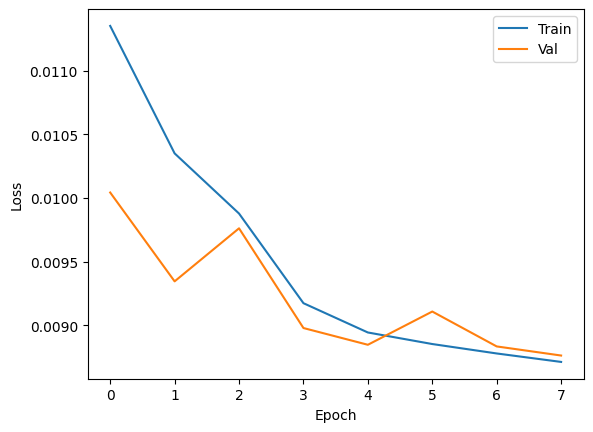

In [43]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
#ax.plot(val_losses, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()
plt.show()